In [1]:
# !pip install -r ../requirements.txt
# !pip install bootstrapped

## Importing Libraries

In [2]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import imblearn
from sklearn.metrics import accuracy_score
sns.set()
sns.set_palette("tab10")


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
import sys

In [3]:
# Note: Data Cleaning was performed using Python. The code used for cleaning has been removed for the sake of simplicity.

### 1. Time Series Classification Part 1: Feature Creation/Extraction

#### An interesting task in machine learning is classification of time series. In this problem, we will classify the activities of humans based on time series obtained by a Wireless Sensor Network.

(a) Download the AReM data from:
https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\%29
 The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity. 1 Each file containis 6 time series collected from activities of the same person, which are called avg rss12, var rss12, avg rss13, var rss13, vg rss23, and ar rss23. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.

(b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

(c) Feature Extraction Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features. 

    i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).
    
#### Answer: Minimum, Maximum, Mean, Median, Standard deviation, Skewness, Kurtosis, k-quantiles etc.

    ii. Extract the time-domain features minimum, maximum, mean, median, stan- dard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly. 
#### Answer: Check the code cell below.

In [4]:
def get_parts(df,n_parts):
        '''Splits data into n parts. Returns: pd.Dataframe'''
        z = pd.DataFrame()
        i = 0
        c = df.shape[0]//n_parts
        k = df.shape[0]//n_parts
        for part in range(1,n_parts+1):
            x = df[i:c].describe().T[['mean','std','min','25%','50%','75%','max']]
            if part != 1:
                x.columns = [f'mean_{part}',f'std_{part}',f'min_{part}',f'25%_{part}',f'median_{part}',f'75%_{part}',f'max_{part}']      
            else:
                x.columns = ['mean','std','min','25%','median','75%','max']

            z = pd.concat([z,x.unstack().to_frame().sort_index(level=1).T],axis=1)
            i = c
            c = i+k            
        return z

def get_train_test(n_parts:int):
        '''Gets data from the directories and splits it into train and test sets'''
        test = pd.DataFrame()
        train = pd.DataFrame()
        for root, dirs, files in os.walk("..\data", topdown=False):

            for name in files:
                if name in ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']:
                    continue
                
                directory = root.split(os.path.sep)[-1]
                df = pd.read_csv(root+"/"+name,skiprows=5,header=None,\
                                 names=["time","1","2","3","4","5","6"])
                df.drop("time",axis=1,inplace=True)
                z = get_parts(df,n_parts)
                z.columns = z.columns.map('_'.join)
                z['class'] = directory
            
                if directory == "bending1" or directory == "bending2":
                    if name == "dataset1.csv" or name == "dataset2.csv":
                        test = pd.concat([test,z],axis=0)    
                    else:
                        train = pd.concat([train,z],axis=0)
                else:
                    if name == "dataset1.csv" or name == "dataset2.csv" or name == "dataset3.csv":
                        test = pd.concat([test,z],axis=0)
                    else:
                        train = pd.concat([train,z],axis=0)

        train = train.reset_index().drop('index',axis=1)
        test = test.reset_index().drop('index',axis=1)
        return train,test
    
train, test = get_train_test(1)

In [5]:
print("Test Shape",test.shape)
print("Train Shape",train.shape)

Test Shape (19, 43)
Train Shape (69, 43)


iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [6]:
df = pd.concat([test,train],ignore_index=True,axis=0)
df_features = df.drop(['class'],axis=1)
df_features.std()

25%_1       6.153590
75%_1       5.138925
max_1       4.394362
mean_1      5.335718
median_1    5.440054
min_1       9.569975
std_1       1.772153
25%_2       0.946386
75%_2       2.125266
max_2       5.062729
mean_2      1.574164
median_2    1.412244
min_2       0.000000
std_2       0.884105
25%_3       4.220658
75%_3       4.171628
max_3       4.875137
mean_3      4.008380
median_3    4.036396
min_3       2.956462
std_3       0.946710
25%_4       0.843620
75%_4       1.552504
max_4       2.183625
mean_4      1.166114
median_4    1.145586
min_4       0.000000
std_4       0.458242
25%_5       6.096465
75%_5       5.531720
max_5       5.741238
mean_5      5.675593
median_5    5.813782
min_5       6.124001
std_5       1.024898
25%_6       0.758584
75%_6       1.523599
max_6       2.518921
mean_6      1.154812
median_6    1.086474
min_6       0.045838
std_6       0.517617
dtype: float64

In [7]:
# df_features.std(ddof=0).head(6)
lbound = []
ubound = []
columns = df_features.columns
for col in columns:
    
    #degree of freedom = 0
    ci = bs.bootstrap(df_features[col].values,stat_func=bs_stats.std,alpha = 0.1)
    lbound.append(ci.lower_bound)
    ubound.append(ci.upper_bound)
    
pd.DataFrame({"Time-domain Features":columns, "Standard Deviation":df_features.std(),"Lower Bound(CI)":lbound,"Upper Bound(CI)":ubound})

,Time-domain Features,Standard Deviation,Lower Bound(CI),Upper Bound(CI)
25%_1,25%_1,6.153590,5.626597,6.687431
75%_1,75%_1,5.138925,4.426508,5.899143
max_1,max_1,4.394362,3.480655,5.392430
mean_1,mean_1,5.335718,4.766656,5.935212
median_1,median_1,5.440054,4.855754,6.043791
min_1,min_1,9.569975,8.307751,10.843781
std_1,std_1,1.772153,1.580410,1.959188
25%_2,25%_2,0.946386,0.852765,1.056840
75%_2,75%_2,2.125266,1.942211,2.346564
max_2,max_2,5.062729,4.689210,5.469983


iv. Use your judgement to select the three most important time-domain features.

### I select:

1. Mean: As data distribution is continuous.
2. Median: It is a robust measure least affected by outliers.
3. Standard deviation: It measures the dispersion in data.

### 2. ISLR 3.7.4

I collect a set of data (n = 100 observations) containing a single
predictor and a quantitative response. I then fit a linear regression
model to the data, as well as a separate cubic regression, i.e. Y =
β0 + β1X + β2X2 + β3X3 + ϵ.

#### (a) Suppose that the true relationship between X and Y is linear, i.e. Y = β0 + β1X + ϵ. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

Answer: I expect the RSS for the cubic regression to be lower than that of linear regression because a flexible model will fit more closely variance in the training data despite that the true relationship between X and Y is linear.

#### b) Answer (a) using test rather than training RSS.

Answer: For test RSS, a linear model will perform better as the assumption of high bias is correct. A cubic model on the other hand overfits the training data. The fit of this model will be affected by the variance in the training data. 

#### (c) Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

Answer: The training RSS will reduce with increase in "flexibility" regardless of what the true underlying model is. Training RSS for cubic regression will be less than that of linear regression as it will fit more closely variance in the training data.

#### (d) Answer (c) using test rather than training RSS.

Answer: There is not enough information to tell. 

- If the **true underlying model is simple**, we expect the **RSS for linear regression model to be lower** than that of cubic regression because our assumption of low bias was true. The cubic regression model will overfit the training data.

- If the **true underlying model is highly non-linear**, we expect the **RSS for cubic regression(flexible model)** to be lower than that of linear regression because the true model has high variance. Linear regression will probably underfit the training data.

# Part 2: Homework 4

### 2. Time Series Classification Part 2: Binary and Multiclass Classification 

#### (a) Binary Classification Using Logistic Regression

i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook)

In [8]:
train1 = train.copy()
train1.loc[(train1['class']=="bending1") | (train1['class']=="bending2"),"class"] = "bending"
train1.loc[(train1['class']!="bending"),"class"] = "other"

In [9]:
train1['class'].value_counts()

other      60
bending     9
Name: class, dtype: int64

<Figure size 936x936 with 0 Axes>

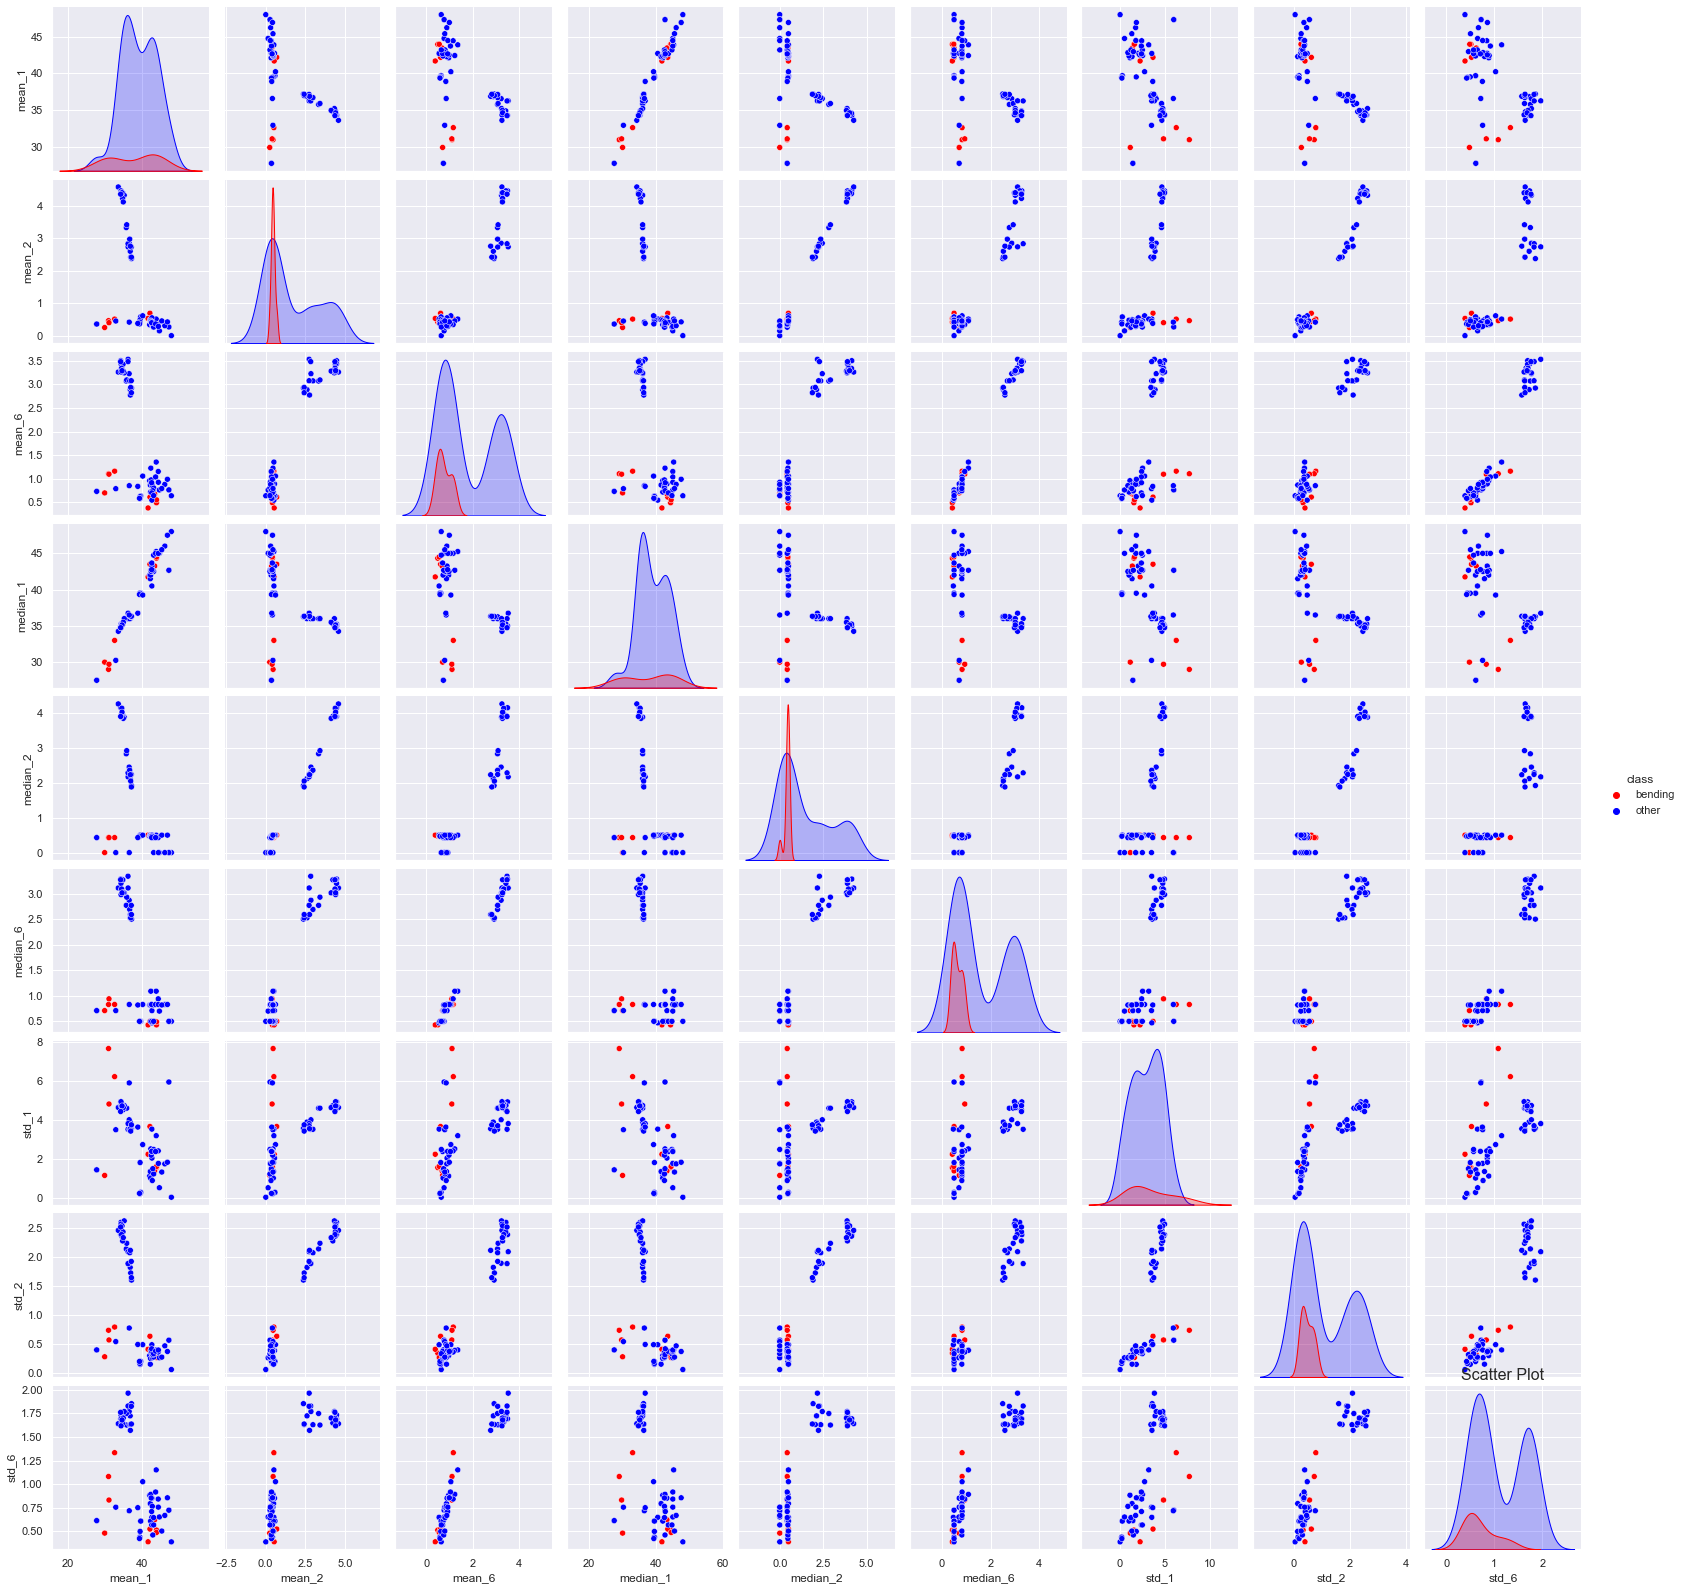

In [10]:
#Scatter plot
plt.figure(figsize = (13,13))
sns.pairplot(train1[['mean_1', 'mean_2','mean_6',\
                     'median_1','median_2','median_6',\
                     'std_1','std_2','std_6','class']],hue='class',palette = ['red','blue'])
plt.title("Scatter Plot",fontsize=16)
plt.show()

#### ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?

In [11]:
train2,test2 = get_train_test(n_parts=2)

In [12]:
train2i = train2[['mean_1','mean_2','mean_6','mean_2_1','mean_2_2','mean_2_6',\
      'median_1','median_2','median_6','median_2_1','median_2_2','median_2_6',\
      'std_1','std_2','std_6','std_2_1','std_2_2','std_2_6','class']]

train2i.loc[(train2i['class']=="bending1") | (train2i['class']=="bending2"),"class"] = "bending"
train2i.loc[(train2i['class']!="bending"),"class"] = "other"

<Figure size 936x936 with 0 Axes>

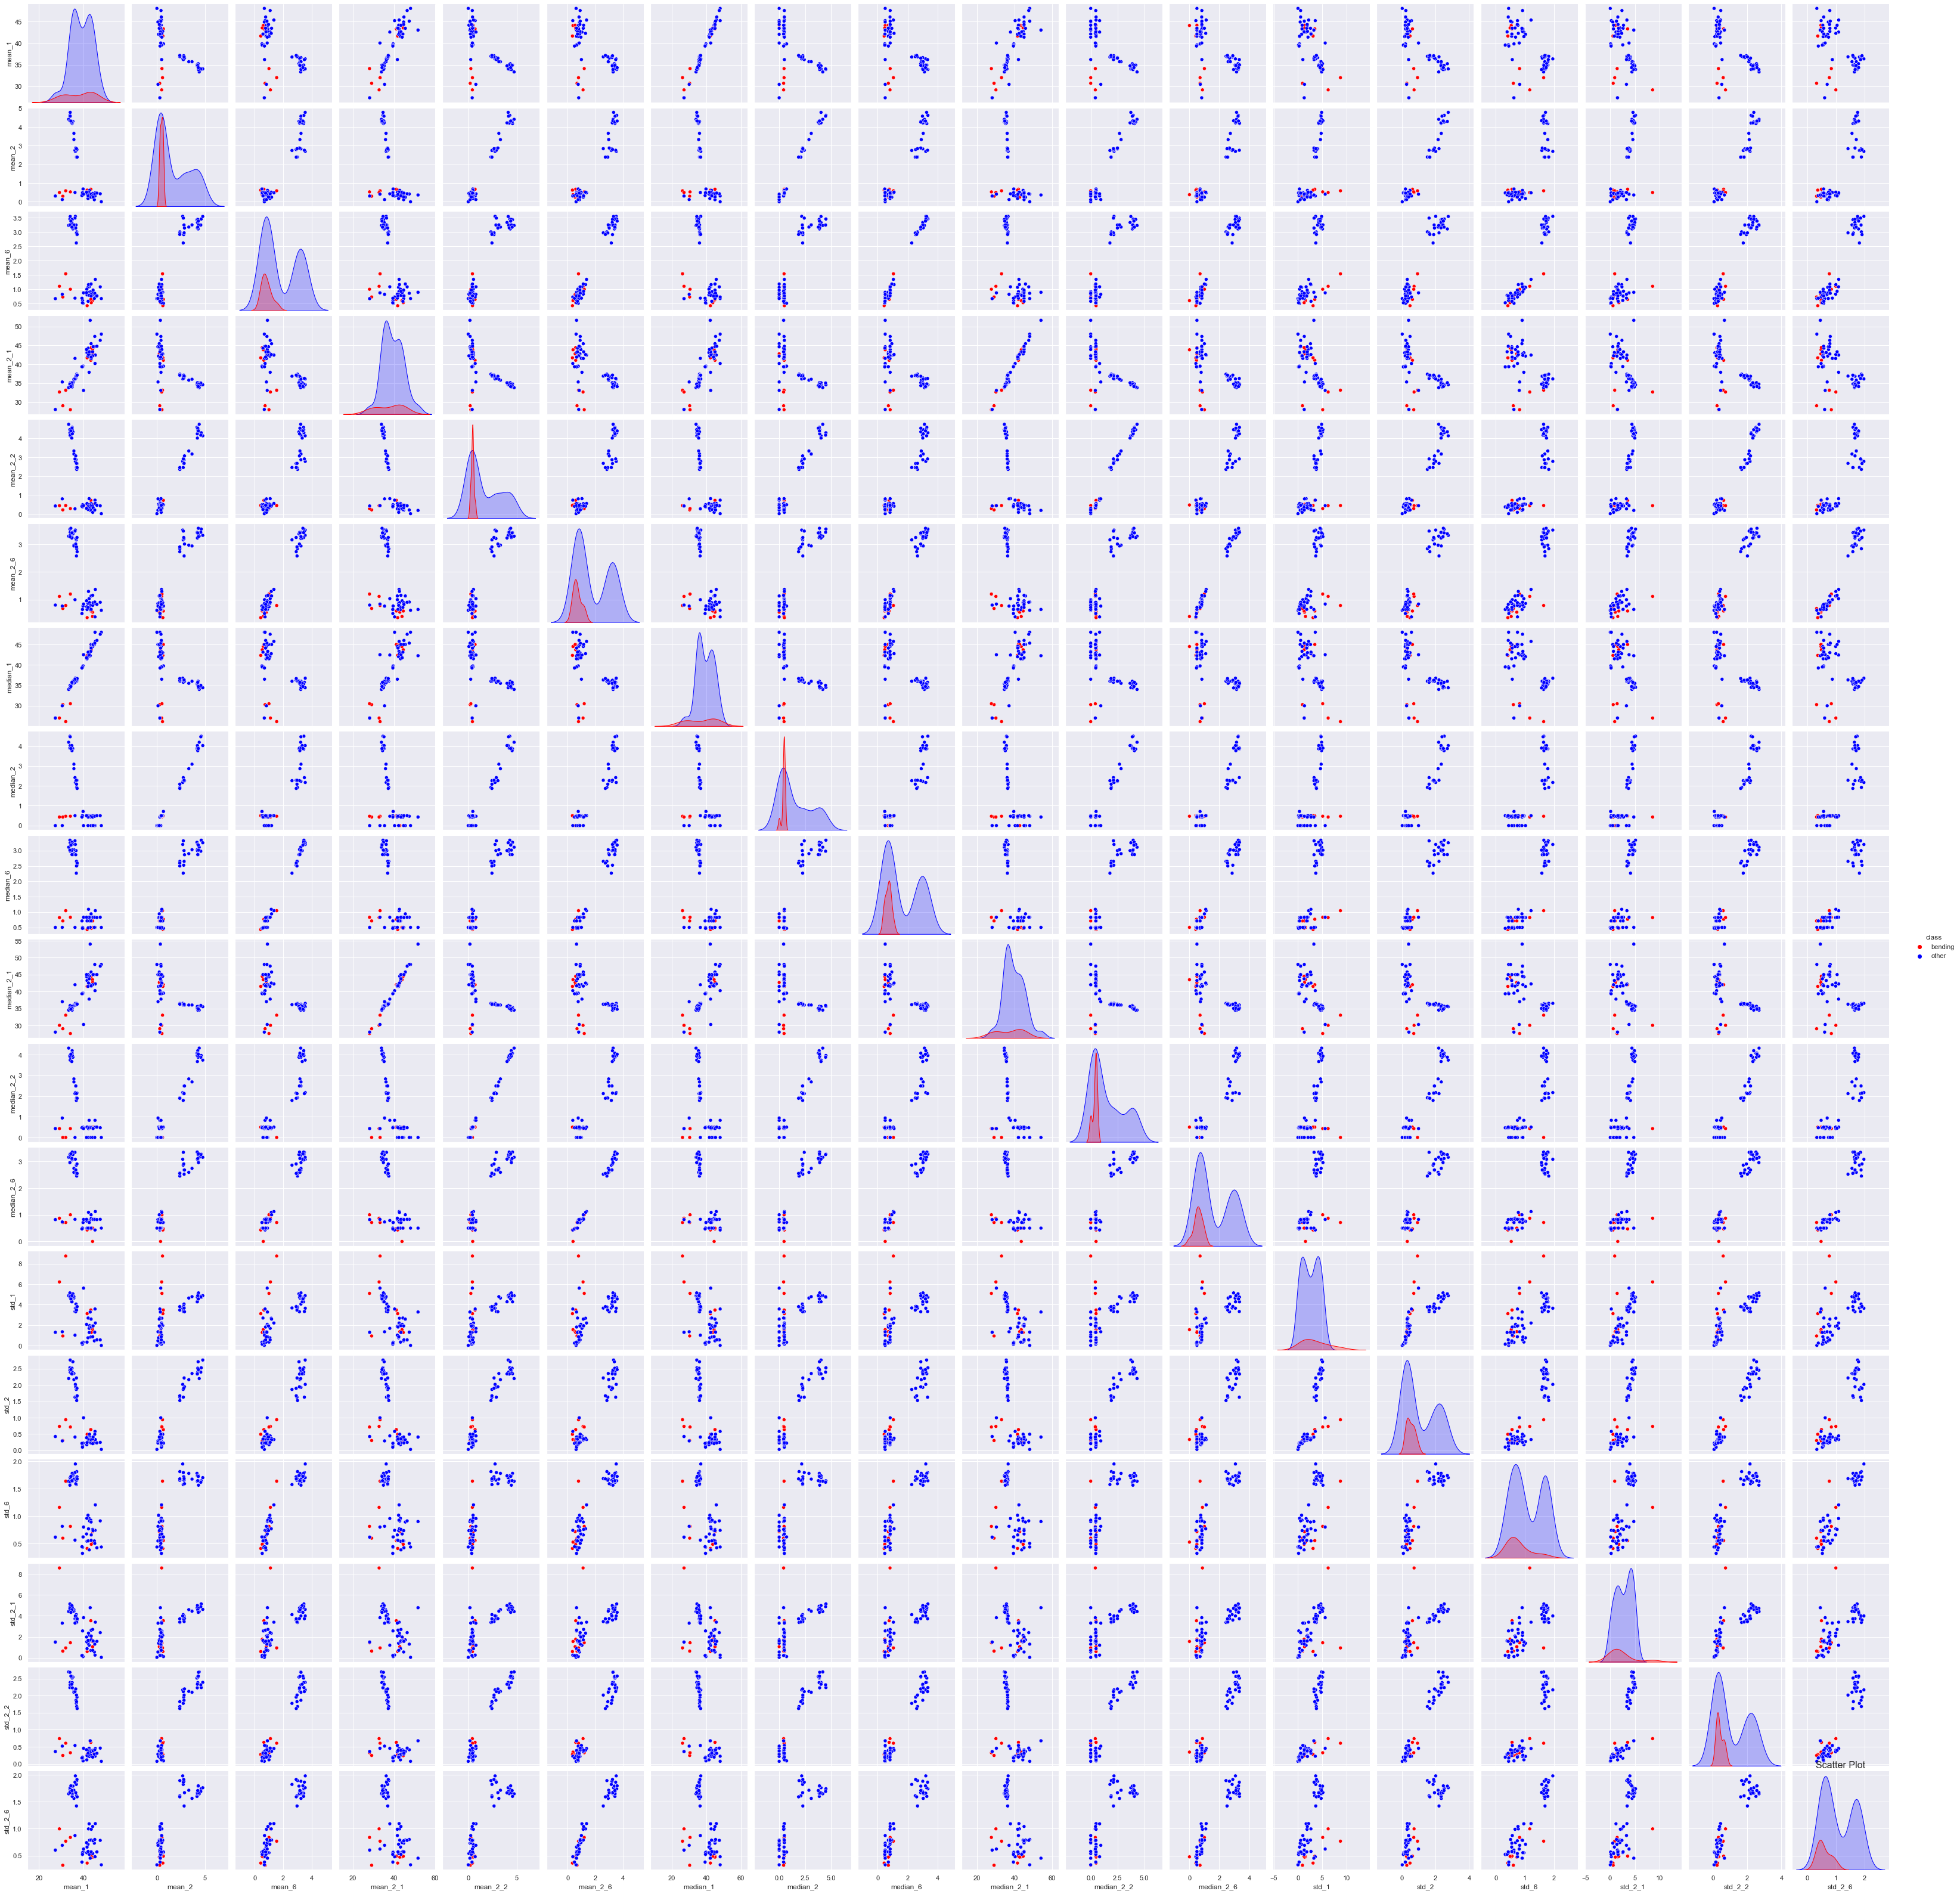

In [13]:
#Part 1: mean_1, median_1,std_1
#Part 2: mean_2_1, median_2_1, std_2_1

plt.figure(figsize = (13,13))
sns.pairplot(data=train2i,hue='class',palette = ['red','blue'])
plt.title("Scatter Plot",fontsize=16)
plt.show()

#### Do you see any considerable difference in the results with those of 2(a)i?

After splitting the classes appears to be more seperable. 

#### iii. 
- **Break each time series in your training set into l ∈ { 1 , 2 , . . . , 20 } time series** of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance.
- Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. 
- **Alternatively, you can use backward selection** using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair ( l, p ), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! 
- Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use **stratified cross validation**. Research what it means and use it if needed.

In [14]:
lp = {"L":[],
     "Accuracy_p":[],
     "Area_Under_Curve":[],
     "AUC_list":[],
     "feature_groups":[]}

for l in range(1,21):
    
    #Getting a train and test sets with l parts
    train,test = get_train_test(n_parts=l)
    c = train.columns
    #Getting the names of columns with 3 features selected
    means = c[c.str.contains('mean')]
    medians = c[c.str.contains('median')]
    stds = c[c.str.contains('std')]
    
    #Getting 3 features(mean, median, mode) for "l" parts
    train = pd.concat([train[means],train[medians],train[stds],train['class']],axis=1)
    train.loc[(train['class']=="bending1") | (train['class']=="bending2"),"class"] = 'bending'
    train.loc[(train['class']!="bending"),"class"] = 'other'

    #Getting 3 features(mean, median, mode) for "l" parts
    test = pd.concat([test[means],test[medians],test[stds],test['class']],axis=1)
    test.loc[(test['class']=="bending1") | (test['class']=="bending2"),"class"] = 'bending'
    test.loc[(test['class']!="bending"),"class"] = 'other'
    
    #Getting the X and y datasets
    X = train.drop('class',axis=1)
    y = train['class']
    
    #Encoding "class": response variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    accuracy = [] # accuracy: Stores the mean accuracy over 5 folds.
    auc_score = [] # auc_score: Stores the mean score over 5 folds.
    feature_groups = [] #Stores best features for each fold

    #Stratified K-Fold with 5 folds
    stratifiedKFolds = StratifiedKFold(n_splits=5,shuffle=False)
    for trainIdx, valIdx in stratifiedKFolds.split(X,y):
        
        # Getting the training data
        Xtrain_list = []
        Ytrain_list = []
        for idx in trainIdx:  
            Xtrain_list.append(X.loc[idx,:])
            Ytrain_list.append(y[idx])
        
        Xtrain1 = pd.DataFrame(Xtrain_list)
        ytrain1 = np.array(Ytrain_list)

        # Getting the validation data
        Xval_list = []
        Yval_list = []
        for idx in valIdx:
            Xval_list.append(X.loc[idx,:])
            Yval_list.append(y[idx])
            
        Xval1 = pd.DataFrame(Xval_list)
        yval1 = np.array(Yval_list)

        # Selecting the best predictors
        columns = Xtrain1.columns
        loreg = LogisticRegression(solver='liblinear')
        rfecv = RFECV(estimator=loreg, cv=StratifiedKFold(5))
        rfecv.fit(Xtrain1,ytrain1)
        ranking = rfecv.ranking_
        
        #Getting the best features
        best_features = []
        for i in range(len(ranking)):
            if ranking[i]==1:
                best_features.append(columns[i])

        #Getting dataset with the best  features
        Xtrain1 = Xtrain1[best_features]
        Xval1 = Xval1[best_features]
    
        loreg1 = LogisticRegression(solver='liblinear')
        loreg1.fit(Xtrain1,ytrain1)
        
        # Finding accuracy on cross-validation data
        val_acc = loreg1.score(Xval1,yval1)
        val_probas = loreg1.predict_proba(Xval1)
        val_auc = roc_auc_score(yval1,val_probas[::,-1])
        
        accuracy.append(val_acc)
        auc_score.append(val_auc)
        feature_groups.append([])
        feature_groups[-1].append(best_features)

    lp['L'].append(l)
    lp['AUC_list'].append(auc_score)
    lp['Accuracy_p'].append(np.mean(accuracy))
    lp['Area_Under_Curve'].append(np.mean(auc_score))
    lp['feature_groups'].append(feature_groups)

#### iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression β i ’s as well as the p-values associated with them.

#### v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [15]:
table  = pd.DataFrame(lp)
table

,L,Accuracy_p,Area_Under_Curve,AUC_list,feature_groups
0,1,0.941758,0.991667,"[1.0, 1.0, 0.9583333333333333, 1.0, 1.0]","[[[mean_1, mean_2, mean_3, mean_5, median_3, m..."
1,2,0.913187,0.966667,"[1.0, 0.9583333333333333, 0.9166666666666667, ...","[[[mean_5, mean_2_2, std_2_3]], [[mean_3, mean..."
2,3,0.957143,0.950000,"[1.0, 0.9583333333333333, 0.9583333333333333, ...","[[[mean_5, mean_2_1, std_2_1]], [[mean_3, mean..."
3,4,0.942857,0.883333,"[1.0, 0.9583333333333333, 1.0, 0.4583333333333...","[[[mean_5, mean_3_2, mean_4_5, median_3_1, std..."
4,5,0.971429,0.975000,"[1.0, 0.9166666666666666, 0.9583333333333333, ...","[[[mean_5, mean_4_1, std_3_1]], [[mean_5, mean..."
5,6,0.942857,0.966667,"[1.0, 0.9166666666666666, 0.9166666666666667, ...","[[[mean_5, mean_2_5, mean_4_2, mean_5_1, mean_..."
6,7,0.942857,0.983333,"[1.0, 0.9583333333333333, 0.9583333333333333, ...","[[[mean_5, mean_2_5, mean_5_1, mean_5_2, mean_..."
7,8,0.927473,0.983333,"[1.0, 0.9583333333333333, 0.9583333333333333, ...","[[[mean_5, mean_2_5, mean_3_5, median_5_1, std..."
8,9,0.942857,0.983333,"[1.0, 0.9583333333333333, 0.9583333333333333, ...","[[[mean_5, mean_2_5, mean_3_5, mean_6_1, mean_..."
9,10,0.957143,0.966667,"[1.0, 1.0, 0.9166666666666666, 0.9166666666666...","[[[mean_5, mean_2_5, mean_3_5, mean_6_2, mean_..."


In [16]:
best_l = table["Area_Under_Curve"].argmax() + 1
print("\nBest L:",best_l)
train4,test4 = get_train_test(n_parts=best_l)
train4.loc[(train4['class']=="bending1") | (train4['class']=="bending2"),"class"] = 'bending'
train4.loc[(train4['class']!="bending"),"class"] = 'other'

test4.loc[(test4['class']=="bending1") | (test4['class']=="bending2"),"class"] = 'bending'
test4.loc[(test4['class']!="bending"),"class"] = 'other'


Best L: 18


In [17]:
from sklearn.metrics import confusion_matrix,roc_curve,auc
from sklearn.feature_selection import chi2

#Getting AUC scores for each fold

auc_cross_val = table.loc[best_l,"AUC_list"]
print("\nAUC:",auc_cross_val)

#Getting the group with the least features(p), as AUC scores are equal 1.0
minimum = np.inf
selected_features = None
for group in table.loc[best_l-1,"feature_groups"]:
    len_g = len(group[0])
    if len_g < minimum:
        minimum = len_g
        selected_features = group[0]
        
Xtrain = train4[selected_features]
ytrain = train4["class"]

Xtest = test4[selected_features]
ytest = test4["class"]
le = LabelEncoder()
le.fit(ytrain)
ytrain = le.transform(ytrain)
ytest = le.transform(ytest)


AUC: [1.0, 1.0, 0.9166666666666666, 0.8333333333333333, 1.0]


Betas: [[-0.85212884  0.56614789  0.58902108 -0.6277492 ]]


P-Values associated with Parameters:

mean_3_5 : 1.8030105353966548e-23

mean_15_1 : 0.2478219720437449

median_3_3 : 0.17020696959152493

median_3_5 : 2.4981844763081585e-23




Confusion Matrix for Train Data:


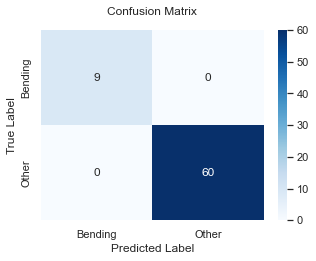




Confusion Matrix for Test Data:





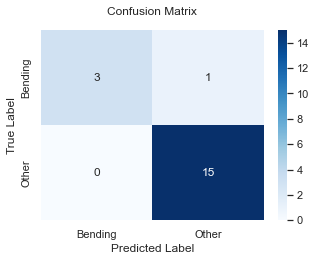




ROC_AUC_Score (Test Data) 0.875
ROC_AUC_Score (Train Data) 1.0


In [18]:
#Modelling logistic regression
l = LogisticRegression(solver='liblinear')
l.fit(Xtrain,ytrain)
ypred_test = l.predict(Xtest)
ypred_train = l.predict(Xtrain)
#Betas
print("Betas:",l.coef_)

print("\n")
print("P-Values associated with Parameters:\n")

#p-value
_, pValues = chi2(Xtrain,ytrain)

for column,b1 in zip(Xtrain.columns,pValues):
    print(column,":",b1)
    print()

print("\n\n")
print("Confusion Matrix for Train Data:")

#Plotting the confusion matrix (Train Data)
plt.figure(figsize=(5,3.5))
sns.heatmap(confusion_matrix(ytrain,ypred_train),annot=True,cmap="Blues", fmt="d", 
            xticklabels = ['Bending','Other'], 
            yticklabels = ['Bending','Other'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix",pad=15)
plt.show()


print("\n\n")
print("Confusion Matrix for Test Data:\n\n\n")

#Plotting the confusion matrix (Test Data)
plt.figure(figsize=(5,3.5))
sns.heatmap(confusion_matrix(ytest,ypred_test),annot=True,cmap="Blues", fmt="d", 
            xticklabels = ['Bending','Other'], 
            yticklabels = ['Bending','Other'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix",pad=15)
plt.show()

print("\n\n")
print("ROC_AUC_Score (Test Data)", roc_auc_score(ytest,ypred_test))
print("ROC_AUC_Score (Train Data)", roc_auc_score(ytrain,ypred_train))

#### ROC curve Train Data

ROC_AUC_Score (Train Data) 1.0


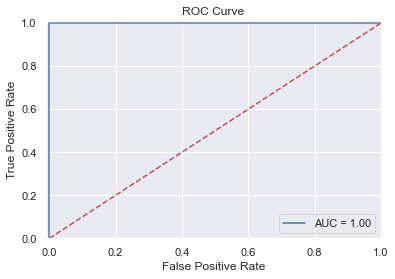

ROC_AUC_Score (Test Data) 0.9333333333333333


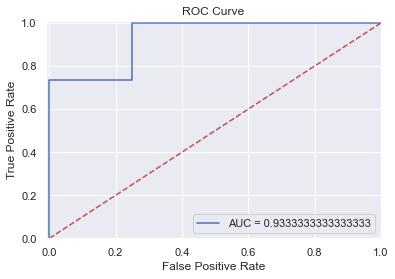

In [19]:
#Train Data
probs = l.predict_proba(Xtrain)[:,-1]
fpr, tpr, threshold = roc_curve(ytrain, probs)
roc_auc = auc(fpr, tpr)
print("ROC_AUC_Score (Train Data)",roc_auc)
import matplotlib.pyplot as plt
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Test Data
probs = l.predict_proba(Xtest)[:,-1]
fpr, tpr, threshold = roc_curve(ytest, probs)
roc_auc = auc(fpr, tpr)
print("ROC_AUC_Score (Test Data)",roc_auc)
import matplotlib.pyplot as plt
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [20]:
#Comparing the test accuracy with cross_val_accuracy
accuracy_score(ytest,ypred_test)

0.9473684210526315

In [21]:
#Mean accuracy for validation set for 5 folds
table.iloc[best_l-1]["Accuracy_p"]

0.9857142857142858

#### The difference between the validation accuracy and test accuracy is less. Our model is performing well, but it can perform better.

#### vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

- The classes (bending and non-bending) are not well separated. 
- Thus, with K-fold Cross Validation, there is a possiblity that some folds may not get any samples from the minority class. 
- So, to solve this problem, Stratified K-fold Cross Validation is used to handle class imbalance. Stratified K-fold Cross Validation has reduced the instability in calculating the parameters for logistic regression.

#### vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

Yes, the datasets are imbalanced.

In [22]:
# from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy="minority")
Xtrain_sm, ytrain_sm = smote.fit_resample(Xtrain,ytrain)

#Checking the class distribution
np.unique(ytrain_sm,return_counts=True)

(array([0, 1]), array([60, 60], dtype=int64))

In [23]:
l = LogisticRegression(solver = "liblinear")

In [24]:
l.fit(Xtrain_sm,ytrain_sm)

LogisticRegression(solver='liblinear')

In [25]:
ypred_train = l.predict(Xtrain)
ypred_test = l.predict(Xtest)

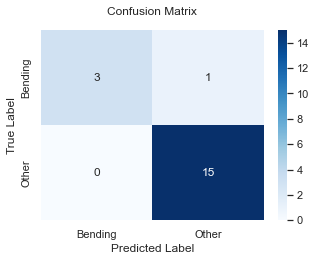




ROC_AUC_Score (Test Data) 0.875
ROC_AUC_Score (Train Data) 1.0



Accuracy (Test Data) 0.9473684210526315
Accuracy (Train Data) 1.0


ROC Curve for Test Data


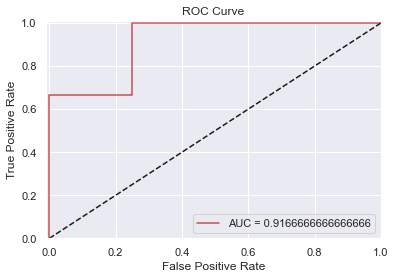

In [26]:
#Plotting the confusion matrix (Test Data)
plt.figure(figsize=(5,3.5))
sns.heatmap(confusion_matrix(ytest,ypred_test),annot=True,cmap="Blues", fmt="d", 
            xticklabels = ['Bending','Other'], 
            yticklabels = ['Bending','Other'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix",pad=15)
plt.show()

#ROC
print("\n\n")
print("ROC_AUC_Score (Test Data)", roc_auc_score(ytest,ypred_test))
print("ROC_AUC_Score (Train Data)", roc_auc_score(ytrain,ypred_train))

print("\n\n")
print("Accuracy (Test Data)", accuracy_score(ytest,ypred_test))
print("Accuracy (Train Data)", accuracy_score(ytrain,ypred_train))

#ROC
#Test Data
print("\n\nROC Curve for Test Data")
probs = l.predict_proba(Xtest)[::,-1]
fpr,tpr,_ = roc_curve(ytest, probs)
roc_auc = auc(fpr, tpr)
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'r', label = f'AUC = {roc_auc}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### (b) Binary Classification Using L 1 -penalized logistic regression

#### i. Repeat 2(a)iii using L 1 -penalized logistic regression i.e. instead of using p- values for variable selection, use L 1 regularization. Note that in this problem, you have to cross-validate for both l , the number of time series into which you break each of your instances, and λ , the weight of L 1 penalty in your logistic regression objective function (or C , the budget). Packages usually perform cross-validation for λ automatically.

In [27]:
from sklearn.preprocessing import MinMaxScaler

lp = {"L":[],
     "Accuracy_p":[],
     "Area_Under_Curve":[],
     "lambda":[]}

for l in range(1,21):
    
    #Getting a train and test sets with l parts
    train,test = get_train_test(n_parts=l)
    c = train.columns

    #Getting the names of columns with 3 features selected
    means = c[c.str.contains('mean')]
    medians = c[c.str.contains('median')]
    stds = c[c.str.contains('std')]
    
    #Getting 3 features(mean, median, mode) for "l" parts
    train = pd.concat([train[means],train[medians],train[stds],train['class']],axis=1)
    train.loc[(train['class']=="bending1") | (train['class']=="bending2"),"class"] = 'bending'
    train.loc[(train['class']!="bending"),"class"] = 'other'

    #Getting 3 features(mean, median, mode) for "l" parts
    test = pd.concat([test[means],test[medians],test[stds],test['class']],axis=1)
    test.loc[(test['class']=="bending1") | (test['class']=="bending2"),"class"] = 'bending'
    test.loc[(test['class']!="bending"),"class"] = 'other'
    
    #Getting the X and y datasets
    X = train.drop('class',axis=1)
    y = train['class']
    
    #Normalization
    n = MinMaxScaler()
    X = n.fit_transform(X.values)
    
    #Encoding "class": response variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    accuracy = []
    auc_score = []
    log_regs = []
    best_lambda = []
    
    #Stratified K-Fold with 5 folds
    stratifiedKFolds = StratifiedKFold(n_splits=5,shuffle=False)

    lambdaV = []
    for trainIdx, valIdx in stratifiedKFolds.split(X,y):
        
        # Getting the training data
        Xtrain_list = []
        Ytrain_list = []
        for idx in trainIdx:  
            Xtrain_list.append(X[idx,:])
            Ytrain_list.append(y[idx])
        
        Xtrain1 = np.array(Xtrain_list)
        ytrain1 = np.array(Ytrain_list)

        # Getting the validation data
        Xval_list = []
        Yval_list = []
        for idx in valIdx:
            Xval_list.append(X[idx,:])
            Yval_list.append(y[idx])
            
        Xval1 = np.array(Xval_list)
        yval1 = np.array(Yval_list)
    
        # For the grid of `Cs` values and `l1_ratios` values, the best hyperparameter is selected by the cross-validator.
        loreg1 = LogisticRegressionCV(solver='liblinear',penalty="l1",cv=5,max_iter=1000)
        loreg1 = loreg1.fit(Xtrain1,ytrain1)
        lambdaV.append(float(1/loreg1.C_[0]))
        
        # Finding accuracy on cross-validation data
        val_acc = loreg1.score(Xval1,yval1)
        val_probas = loreg1.predict_proba(Xval1)
        val_auc = roc_auc_score(yval1,val_probas[::,-1])
        
        accuracy.append(val_acc)
        auc_score.append(val_auc)

    lp['L'].append(l)
    lp['Accuracy_p'].append(np.mean(accuracy))
    lp['Area_Under_Curve'].append(np.mean(auc_score))
    fold_id = np.argmax(auc_score)
    lp['lambda'].append(lambdaV[fold_id])

In [28]:
table2 = pd.DataFrame(lp)
table2

,L,Accuracy_p,Area_Under_Curve,lambda
0,1,0.913187,0.975000,0.046416
1,2,0.913187,0.975000,0.046416
2,3,0.914286,0.941667,0.005995
3,4,0.928571,0.983333,0.046416
4,5,0.913187,0.941667,0.046416
5,6,0.914286,0.933333,0.359381
6,7,0.884615,0.783333,0.000100
7,8,0.898901,0.941667,0.000100
8,9,0.898901,0.941667,0.000774
9,10,0.928571,0.916667,0.359381


In [29]:
best_l = table2.Area_Under_Curve.argmax() + 1
print("Best l:",best_l)
best_lambda = table2.iloc[best_l-1]["lambda"]
print("Best lambda:",best_lambda)

Best l: 4
Best lambda: 0.04641588833612782


In [30]:
train,test = get_train_test(n_parts=best_l)
train.loc[(train['class']=="bending1") | (train['class']=="bending2"),"class"] = 'bending'
train.loc[(train['class']!="bending"),"class"] = 'other'

test.loc[(test['class']=="bending1") | (test['class']=="bending2"),"class"] = 'bending'
test.loc[(test['class']!="bending"),"class"] = 'other'

c = train.columns

#Getting the names of columns with 3 features selected
means = c[c.str.contains('mean')]
medians = c[c.str.contains('median')]
stds = c[c.str.contains('std')]

#Getting 3 features(mean, median, mode) for "l" parts
train = pd.concat([train[means],train[medians],train[stds],train['class']],axis=1)

#Getting 3 features(mean, median, mode) for "l" parts
test = pd.concat([test[means],test[medians],test[stds],test['class']],axis=1)

#Getting the X and y datasets
Xtrain = train.drop('class',axis=1)
Xtest = test.drop('class',axis=1)
ytrain = train['class']
ytest = test['class']

#Normalization
n = MinMaxScaler()
Xtrain = n.fit_transform(Xtrain)
Xtest = n.transform(Xtest)

#Encoding "class": response variable
label_encoder = LabelEncoder()
ytrain = label_encoder.fit_transform(ytrain)
ytest = label_encoder.transform(ytest)

loreg_l1 = LogisticRegression(solver='liblinear', penalty='l1', C=1/best_lambda)
loreg_l1.fit(Xtrain,ytrain)

ypred_train = loreg_l1.predict(Xtrain)
ypred_test = loreg_l1.predict(Xtest)

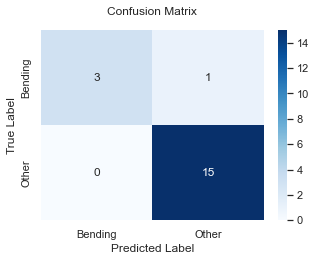




ROC_AUC_Score (Test Data) 0.875
ROC_AUC_Score (Train Data) 1.0



Accuracy (Test Data) 0.9473684210526315
Accuracy (Train Data) 1.0


ROC Curve for Test Data


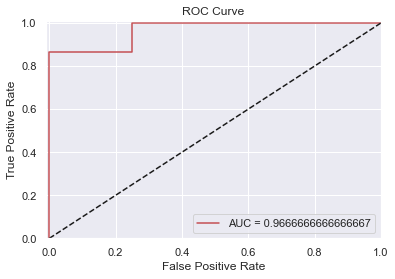

In [31]:
#Plotting the confusion matrix (Test Data)
plt.figure(figsize=(5,3.5))
sns.heatmap(confusion_matrix(ytest,ypred_test),annot=True,cmap="Blues", fmt="d", 
            xticklabels = ['Bending','Other'], 
            yticklabels = ['Bending','Other'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix",pad=15)
plt.show()

#ROC
print("\n\n")
print("ROC_AUC_Score (Test Data)", roc_auc_score(ytest,ypred_test))
print("ROC_AUC_Score (Train Data)", roc_auc_score(ytrain,ypred_train))

print("\n\n")
print("Accuracy (Test Data)", accuracy_score(ytest,ypred_test))
print("Accuracy (Train Data)", accuracy_score(ytrain,ypred_train))

#ROC
#Test Data
print("\n\nROC Curve for Test Data")
probs = loreg_l1.predict_proba(Xtest)[::,-1]
fpr,tpr,_ = roc_curve(ytest, probs)
roc_auc = auc(fpr, tpr)
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'r', label = f'AUC = {roc_auc}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### ii. Compare the L 1 -penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

**The L-1 penalised Logistic Regression model is easier to implement** because we just add one regularization parameter. The accuracy for L-1 penalized data is much better than that of variable selection using p-values; Thus, we can say that **L1-penalized logistic regression performs better.**

### (c) Multi-class Classification (The Realistic Case)

#### i. Find the best l in the same way as you found it in 2(b)i to build an L 1 - penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible. 

In [32]:
from sklearn.preprocessing import MinMaxScaler

lp = {"L":[],
     "Accuracy_p":[],
     "penalty":[]}

for l in range(1,21):
    
    #Getting a train and test sets with l parts
    train,test = get_train_test(n_parts=l)
    c = train.columns

    #Getting the names of columns with 3 features selected
    means = c[c.str.contains('mean')]
    medians = c[c.str.contains('median')]
    stds = c[c.str.contains('std')]
    
    #Getting 3 features(mean, median, mode) for "l" parts
    train = pd.concat([train[means],train[medians],train[stds],train['class']],axis=1)
    train.loc[(train['class']=="bending1") | (train['class']=="bending2"),"class"] = 'bending'

    #Getting 3 features(mean, median, mode) for "l" parts
    test = pd.concat([test[means],test[medians],test[stds],test['class']],axis=1)
    test.loc[(test['class']=="bending1") | (test['class']=="bending2"),"class"] = 'bending'
    
    #Getting the X and y datasets
    X = train.drop('class',axis=1)

    #Normalizing data
    n = MinMaxScaler()
    X = n.fit_transform(X)
    
    y = train['class']
    #Encoding "class": response variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # accuracy: Stores the mean accuracy over 5 folds.
    # auc_score: Stores the mean score over 5 folds.
    accuracy = []
    penalty = []
    
    #Stratified K-Fold with 5 folds
    stratifiedKFolds = StratifiedKFold(n_splits=5,shuffle=False)

    penalties = []
    for trainIdx, valIdx in stratifiedKFolds.split(X,y):
        
        # Getting the training data
        Xtrain_list = []
        Ytrain_list = []
        for idx in trainIdx:  
            Xtrain_list.append(X[idx,:])
            Ytrain_list.append(y[idx])
        
        Xtrain1 = np.array(Xtrain_list)
        ytrain1 = np.array(Ytrain_list)

        # Getting the validation data
        Xval_list = []
        Yval_list = []
        for idx in valIdx:
            Xval_list.append(X[idx,:])
            Yval_list.append(y[idx])
            
        Xval1 = np.array(Xval_list)
        yval1 = np.array(Yval_list)

        # For the grid of `Cs` values and `l1_ratios` values, the best hyperparameter is selected by the cross-validator.
        loreg1 = LogisticRegressionCV(solver='liblinear',penalty="l1",max_iter=1000,cv=5,multi_class='auto')
        loreg1 = loreg1.fit(Xtrain1,ytrain1)
        penalties.append(loreg1.C_)
    
    
        # Finding accuracy on cross-validation data
        val_acc = loreg1.score(Xval1,yval1)
        accuracy.append(val_acc)
        
    lp['L'].append(l)
    lp['Accuracy_p'].append(np.mean(accuracy))
    fold_id = np.argmax(accuracy)
    lp['penalty'].append(penalties[fold_id])

In [33]:
table3 = pd.DataFrame(lp)
table3

,L,Accuracy_p,penalty
0,1,0.883516,"[2.782559402207126, 21.54434690031882, 21.5443..."
1,2,0.840659,"[21.54434690031882, 21.54434690031882, 21.5443..."
2,3,0.884615,"[21.54434690031882, 21.54434690031882, 21.5443..."
3,4,0.854945,"[166.81005372000558, 21.54434690031882, 21.544..."
4,5,0.767033,"[21.54434690031882, 21.54434690031882, 21.5443..."
5,6,0.797802,"[2.782559402207126, 21.54434690031882, 21.5443..."
6,7,0.696703,"[21.54434690031882, 21.54434690031882, 166.810..."
7,8,0.782418,"[21.54434690031882, 2.782559402207126, 2.78255..."
8,9,0.796703,"[21.54434690031882, 21.54434690031882, 21.5443..."
9,10,0.827473,"[2.782559402207126, 166.81005372000558, 166.81..."


In [34]:
#Getting a train and test sets with l parts
best_l = table3["Accuracy_p"].argmax()+1
best_penalties = table3.loc[best_l-1,"penalty"]

train,test = get_train_test(n_parts=best_l)
c = train.columns

#Getting the names of columns with 3 features selected
means = c[c.str.contains('mean')]
medians = c[c.str.contains('median')]
stds = c[c.str.contains('std')]

#Getting 3 features(mean, median, mode) for "l" parts
train = pd.concat([train[means],train[medians],train[stds],train['class']],axis=1)
train.loc[(train['class']=="bending1") | (train['class']=="bending2"),"class"] = 'bending'

#Getting 3 features(mean, median, mode) for "l" parts
test = pd.concat([test[means],test[medians],test[stds],test['class']],axis=1)
test.loc[(test['class']=="bending1") | (test['class']=="bending2"),"class"] = 'bending'

#Getting the X and y datasets
Xtrain = train.drop('class',axis=1)
Xtest = test.drop('class',axis=1)

#Normalizing data
n = MinMaxScaler()
Xtrain = n.fit_transform(Xtrain)
Xtest = n.transform(Xtest)

ytrain = train['class']
ytest = test['class']

#Encoding "class": response variable
label_encoder = LabelEncoder()
ytrain = label_encoder.fit_transform(ytrain)
ytest = label_encoder.transform(ytest)

In [35]:
classes = [i for i in range(len(label_encoder.classes_))]
predictions = []
train_pred = pd.DataFrame()
test_pred = pd.DataFrame()
for Cval,class_name,class_no in zip(best_penalties,label_encoder.classes_,classes):
    
    print(class_name)
    logreg_classi = LogisticRegression(solver='liblinear',penalty='l1',C=Cval,multi_class='auto')
    logreg_classi.fit(Xtrain,ytrain)
    ytrain_proba = logreg_classi.predict_proba(Xtrain)
    ytest_proba = logreg_classi.predict_proba(Xtest)
    
    class_proba_tr = []
    class_proba_te = []
    for i in range(0, len(ytrain_proba)):
        class_proba_tr.append(round(ytrain_proba[i][class_no], 3))
    
    for i in range(0, len(ytest_proba)):    
        class_proba_te.append(round(ytest_proba[i][class_no], 3))

    train_pred[f'{class_no}'] = class_proba_tr
    test_pred[f'{class_no}'] = class_proba_te
 
predictions = train_pred.idxmax(axis=1).astype('int64')
ypred_train = predictions.values
print("\n\nypred_train:\n",ypred_train)

predictions = test_pred.idxmax(axis=1).astype('int64')
ypred_test = predictions.values
print("ypred_test:\n",ypred_test)
ypred_test

print("Train Error: ",1-accuracy_score(ytrain,ypred_train))
print("Test Error: ",1-accuracy_score(ytest,ypred_test))

bending
cycling
lying
sitting
standing
walking


ypred_train:
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5]
ypred_test:
 [0 0 0 4 1 1 1 2 2 2 3 4 3 3 4 4 5 5 5]
Train Error:  0.0
Test Error:  0.1578947368421053


#### Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.


Confusion Matrix for Train Data


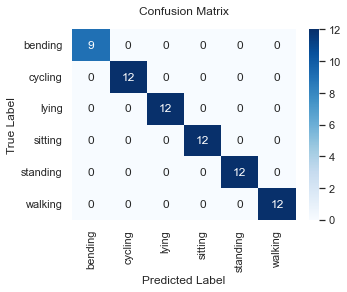


Confusion Matrix for Test Data


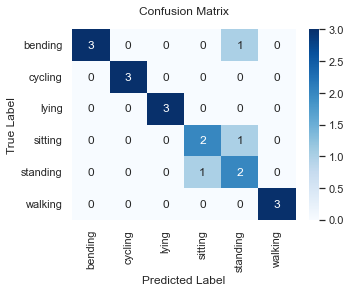



ROC Curve for Train Data:


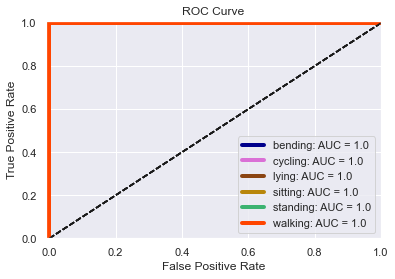



ROC Curve for Test Data:


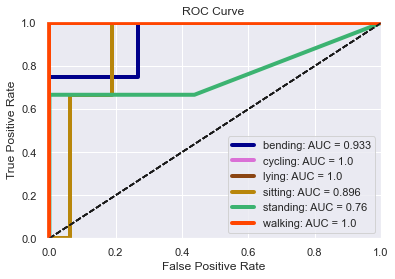

In [36]:
print("\nConfusion Matrix for Train Data")
#Plotting the confusion matrix (Train Data)
plt.figure(figsize=(5,3.5))
sns.heatmap(confusion_matrix(ytrain,ypred_train),annot=True,cmap="Blues", fmt="d", 
            xticklabels = label_encoder.classes_, 
            yticklabels = label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix",pad=15)
plt.show()


print("\nConfusion Matrix for Test Data")
#Plotting the confusion matrix (Test Data)
plt.figure(figsize=(5,3.5))
sns.heatmap(confusion_matrix(ytest,ypred_test),annot=True,cmap="Blues", fmt="d", 
            xticklabels = label_encoder.classes_, 
            yticklabels = label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix",pad=15)
plt.show()


#ROC
#Train Data
print("\n\nROC Curve for Train Data:")

colors = ("darkblue","orchid","saddlebrown","darkgoldenrod","mediumseagreen","orangered")
cnt = 0
col_mapper = dict(zip('012345',label_encoder.classes_))
for i in train_pred.columns:
    
    ytrain_new = [1 if c==int(i) else 0 for c in ytrain]    
    fpr,tpr,_ = roc_curve(ytrain_new,train_pred.loc[:,i].values)
    roc_auc = auc(fpr, tpr)
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, c = colors[cnt],label = f'{col_mapper[i]}: AUC = {round(roc_auc,3)}',lw=4)
    cnt+=1
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'k--')

        
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#ROC
#Test Data
print("\n\nROC Curve for Test Data:")

cnt = 0
col_mapper = dict(zip('012345',label_encoder.classes_))
for i in test_pred.columns:
    
    ytest_new = [1 if c==int(i) else 0 for c in ytest]    
    fpr,tpr,_ = roc_curve(ytest_new,test_pred.loc[:,i].values.flatten())
    roc_auc = auc(fpr, tpr)
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, c = colors[cnt],label = f'{col_mapper[i]}: AUC = {round(roc_auc,3)}',lw=4)
    cnt+=1
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'k--')

        
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### ii. Repeat 2(c)i using a Na ̈ıve Bayes’ classifier. Use both Gaussian and Multi- nomial priors and compare the results.

### Gaussian Naive Bayes Classifier

In [37]:
from sklearn.naive_bayes import GaussianNB

lp = {"L":[],
     "Accuracy_p":[]}

for l in range(1,21):
    
    #Getting a train and test sets with l parts
    train,test = get_train_test(n_parts=l)
    c = train.columns

    #Getting the names of columns with 3 features selected
    means = c[c.str.contains('mean')]
    medians = c[c.str.contains('median')]
    stds = c[c.str.contains('std')]
    
    #Getting 3 features(mean, median, mode) for "l" parts
    train = pd.concat([train[means],train[medians],train[stds],train['class']],axis=1)
    train.loc[(train['class']=="bending1") | (train['class']=="bending2"),"class"] = 'bending'

    #Getting 3 features(mean, median, mode) for "l" parts
    test = pd.concat([test[means],test[medians],test[stds],test['class']],axis=1)
    test.loc[(test['class']=="bending1") | (test['class']=="bending2"),"class"] = 'bending'
    
    #Getting the X and y datasets
    X = train.drop('class',axis=1)    
    y = train['class']
    
    #Encoding "class": response variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # accuracy: Stores the mean accuracy over 5 folds.
    accuracy = []
   
    #Stratified K-Fold with 5 folds
    stratifiedKFolds = StratifiedKFold(n_splits=5,shuffle=False)

    penalties = []
    for trainIdx, valIdx in stratifiedKFolds.split(X,y):
        
        # Getting the training data
        Xtrain_list = []
        Ytrain_list = []
        for idx in trainIdx:  
            Xtrain_list.append(X.loc[idx,:])
            Ytrain_list.append(y[idx])
        
        Xtrain1 = np.array(Xtrain_list)
        ytrain1 = np.array(Ytrain_list)

        # Getting the validation data
        Xval_list = []
        Yval_list = []
        for idx in valIdx:
            Xval_list.append(X.loc[idx,:])
            Yval_list.append(y[idx])
            
        Xval1 = np.array(Xval_list)
        yval1 = np.array(Yval_list)

        gauss = GaussianNB()
        gauss.fit(Xtrain1,ytrain1)
        
        # Finding accuracy on cross-validation data
        val_acc = gauss.score(Xval1,yval1)
        accuracy.append(val_acc)
        
    lp['L'].append(l)
    lp['Accuracy_p'].append(np.mean(accuracy))
   

In [38]:
table5 = pd.DataFrame(lp)
table5

,L,Accuracy_p
0,1,0.825275
1,2,0.827473
2,3,0.768132
3,4,0.796703
4,5,0.826374
5,6,0.796703
6,7,0.783516
7,8,0.796703
8,9,0.797802
9,10,0.854945


In [39]:
#Getting a train and test sets with l parts
best_l = table5["Accuracy_p"].argmax()+1
train,test = get_train_test(n_parts=best_l)
c = train.columns

#Getting the names of columns with 3 features selected
means = c[c.str.contains('mean')]
medians = c[c.str.contains('median')]
stds = c[c.str.contains('std')]

#Getting 3 features(mean, median, mode) for "l" parts
train = pd.concat([train[means],train[medians],train[stds],train['class']],axis=1)
train.loc[(train['class']=="bending1") | (train['class']=="bending2"),"class"] = 'bending'

#Getting 3 features(mean, median, mode) for "l" parts
test = pd.concat([test[means],test[medians],test[stds],test['class']],axis=1)
test.loc[(test['class']=="bending1") | (test['class']=="bending2"),"class"] = 'bending'

#Getting the X and y datasets
Xtrain = train.drop('class',axis=1)
Xtest = test.drop('class',axis=1)

#Normalizing data
# n = MinMaxScaler()
# Xtrain = n.fit_transform(Xtrain)
# Xtest = n.transform(Xtest)

print(Xtrain.shape, Xtest.shape)
ytrain = train['class']
ytest = test['class']

#Encoding "class": response variable
label_encoder = LabelEncoder()
ytrain = label_encoder.fit_transform(ytrain)
ytest = label_encoder.transform(ytest)

(69, 180) (19, 180)


In [40]:
classes = [i for i in range(len(label_encoder.classes_))]
predictions = []
train_pred = pd.DataFrame()
test_pred = pd.DataFrame()

for class_name,class_no in zip(label_encoder.classes_,classes):
    
    print(class_name)
    gauss_classi = GaussianNB()
    gauss_classi = gauss_classi.fit(Xtrain,ytrain)
    ytrain_proba = gauss_classi.predict_proba(Xtrain)
    ytest_proba = gauss_classi.predict_proba(Xtest)

    class_proba_tr = []
    class_proba_te = []
    for i in range(0, len(ytrain_proba)):
        class_proba_tr.append(round(ytrain_proba[i][class_no], 3))
    
    for i in range(0, len(ytest_proba)):    
        class_proba_te.append(round(ytest_proba[i][class_no], 3))

    train_pred[f'{class_no}'] = class_proba_tr
    test_pred[f'{class_no}'] = class_proba_te
 
predictions = train_pred.idxmax(axis=1).astype('int64')
ypred_train = predictions.values
print("ypred_train:\n",ypred_train)

predictions = test_pred.idxmax(axis=1).astype('int64')
ypred_test = predictions.values
print("ypred_train:\n",ypred_train)
ypred_test

print("Train Error: ",1-accuracy_score(ytrain,ypred_train))
print("Test Error: ",1-accuracy_score(ytest,ypred_test))

bending
cycling
lying
sitting
standing
walking
ypred_train:
 [0 0 0 0 0 0 2 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5]
ypred_train:
 [0 0 0 0 0 0 2 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5]
Train Error:  0.01449275362318836
Test Error:  0.10526315789473684



Confusion Matrix for Train Data


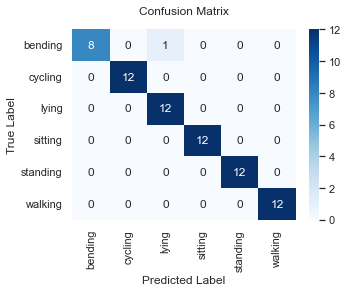


Confusion Matrix for Test Data


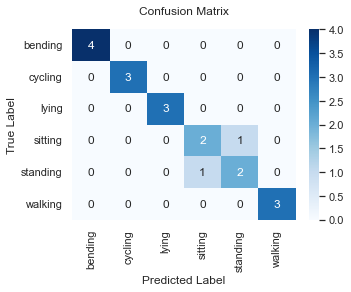



ROC Curve for Train Data:


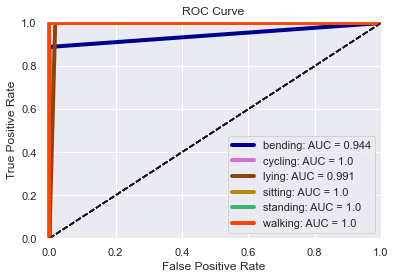



ROC Curve for Test Data:


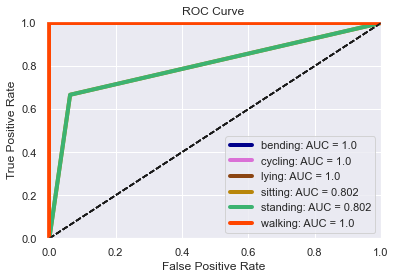

In [41]:
print("\nConfusion Matrix for Train Data")
#Plotting the confusion matrix (Train Data)
plt.figure(figsize=(5,3.5))
sns.heatmap(confusion_matrix(ytrain,ypred_train),annot=True,cmap="Blues", fmt="d", 
            xticklabels = label_encoder.classes_, 
            yticklabels = label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix",pad=15)
plt.show()


print("\nConfusion Matrix for Test Data")
#Plotting the confusion matrix (Test Data)
plt.figure(figsize=(5,3.5))
sns.heatmap(confusion_matrix(ytest,ypred_test),annot=True,cmap="Blues", fmt="d", 
            xticklabels = label_encoder.classes_, 
            yticklabels = label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix",pad=15)
plt.show()


#ROC
#Train Data
print("\n\nROC Curve for Train Data:")

colors = ("darkblue","orchid","saddlebrown","darkgoldenrod","mediumseagreen","orangered")
cnt = 0
col_mapper = dict(zip('012345',label_encoder.classes_))
for i in train_pred.columns:
    
    ytrain_new = [1 if c==int(i) else 0 for c in ytrain]    
    fpr,tpr,_ = roc_curve(ytrain_new,train_pred.loc[:,i].values)
    roc_auc = auc(fpr, tpr)
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, c = colors[cnt],label = f'{col_mapper[i]}: AUC = {round(roc_auc,3)}',lw=4)
    cnt+=1
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'k--')

        
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#ROC
#Test Data
print("\n\nROC Curve for Test Data:")

cnt = 0
col_mapper = dict(zip('012345',label_encoder.classes_))
for i in test_pred.columns:
    ytest_new = [1 if c==int(i) else 0 for c in ytest]    
    fpr,tpr,_ = roc_curve(ytest_new,test_pred.loc[:,i].values.flatten())
    roc_auc = auc(fpr, tpr)
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, c = colors[cnt],label = f'{col_mapper[i]}: AUC = {round(roc_auc,3)}',lw=4)
    cnt+=1
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'k--')

        
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Multinomial 

In [42]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB

lp = {"L":[],
     "Accuracy_p":[]}

for l in range(1,21):
    
    #Getting a train and test sets with l parts
    train,test = get_train_test(n_parts=l)
    c = train.columns

    #Getting the names of columns with 3 features selected
    means = c[c.str.contains('mean')]
    medians = c[c.str.contains('median')]
    stds = c[c.str.contains('std')]
    
    #Getting 3 features(mean, median, mode) for "l" parts
    train = pd.concat([train[means],train[medians],train[stds],train['class']],axis=1)
    train.loc[(train['class']=="bending1") | (train['class']=="bending2"),"class"] = 'bending'

    #Getting 3 features(mean, median, mode) for "l" parts
    test = pd.concat([test[means],test[medians],test[stds],test['class']],axis=1)
    test.loc[(test['class']=="bending1") | (test['class']=="bending2"),"class"] = 'bending'
    
    #Getting the X and y datasets
    X = train.drop('class',axis=1)
    y = train['class']

#     #Normalizing data
#     n = MinMaxScaler()
#     X = n.fit_transform(X)
    
    #Encoding "class": response variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # accuracy: Stores the mean accuracy over 5 folds.
    accuracy = []
   
    #Stratified K-Fold with 5 folds
    stratifiedKFolds = StratifiedKFold(n_splits=5,shuffle=False)

    penalties = []
    for trainIdx, valIdx in stratifiedKFolds.split(X,y):
        
        # Getting the training data
        Xtrain_list = []
        Ytrain_list = []
        for idx in trainIdx:  
            Xtrain_list.append(X.loc[idx,:])
            Ytrain_list.append(y[idx])
        
        Xtrain1 = np.array(Xtrain_list)
        ytrain1 = np.array(Ytrain_list)

        # Getting the validation data
        Xval_list = []
        Yval_list = []
        for idx in valIdx:
            Xval_list.append(X.loc[idx,:])
            Yval_list.append(y[idx])
            
        Xval1 = np.array(Xval_list)
        yval1 = np.array(Yval_list)

        multiNB = MultinomialNB()
        multiNB.fit(Xtrain1,ytrain1)
        
        # Finding accuracy on cross-validation data
        val_acc = multiNB.score(Xval1,yval1)
        accuracy.append(val_acc)
        
    lp['L'].append(l)
    lp['Accuracy_p'].append(np.mean(accuracy))

In [43]:
table6 = pd.DataFrame(lp)
table6

,L,Accuracy_p
0,1,0.796703
1,2,0.812088
2,3,0.782418
3,4,0.826374
4,5,0.826374
5,6,0.856044
6,7,0.826374
7,8,0.826374
8,9,0.840659
9,10,0.826374


In [44]:
#Getting a train and test sets with l parts
best_l = table6["Accuracy_p"].argmax()+1
train,test = get_train_test(n_parts=best_l)
c = train.columns

#Getting the names of columns with 3 features selected
means = c[c.str.contains('mean')]
medians = c[c.str.contains('median')]
stds = c[c.str.contains('std')]

#Getting 3 features(mean, median, mode) for "l" parts
train = pd.concat([train[means],train[medians],train[stds],train['class']],axis=1)
train.loc[(train['class']=="bending1") | (train['class']=="bending2"),"class"] = 'bending'

#Getting 3 features(mean, median, mode) for "l" parts
test = pd.concat([test[means],test[medians],test[stds],test['class']],axis=1)
test.loc[(test['class']=="bending1") | (test['class']=="bending2"),"class"] = 'bending'

#Getting the X and y datasets
Xtrain = train.drop('class',axis=1)
Xtest = test.drop('class',axis=1)

# #Normalizing data
# n = MinMaxScaler()
# Xtrain = n.fit_transform(Xtrain)
# Xtest = n.transform(Xtest)

print(Xtrain.shape, Xtest.shape)
ytrain = train['class']
ytest = test['class']

#Encoding "class": response variable
label_encoder = LabelEncoder()
ytrain = label_encoder.fit_transform(ytrain)
ytest = label_encoder.transform(ytest)

(69, 108) (19, 108)


In [45]:
classes = [i for i in range(len(label_encoder.classes_))]
predictions = []
train_pred = pd.DataFrame()
test_pred = pd.DataFrame()

for class_name,class_no in zip(label_encoder.classes_,classes):
    
    print(class_name)
    gauss_classi = GaussianNB()
    gauss_classi = gauss_classi.fit(Xtrain,ytrain)
    ytrain_proba = gauss_classi.predict_proba(Xtrain)
    ytest_proba = gauss_classi.predict_proba(Xtest)

    class_proba_tr = []
    class_proba_te = []
    for i in range(0, len(ytrain_proba)):
        class_proba_tr.append(round(ytrain_proba[i][class_no], 3))
    
    for i in range(0, len(ytest_proba)):    
        class_proba_te.append(round(ytest_proba[i][class_no], 3))

    train_pred[f'{class_no}'] = class_proba_tr
    test_pred[f'{class_no}'] = class_proba_te
 
predictions = train_pred.idxmax(axis=1).astype('int64')
ypred_train = predictions.values
print("ypred_train:\n",ypred_train)

predictions = test_pred.idxmax(axis=1).astype('int64')
ypred_test = predictions.values
print("ypred_train:\n",ypred_train)
ypred_test

print("Train Error: ",1-accuracy_score(ytrain,ypred_train))
print("Test Error: ",1-accuracy_score(ytest,ypred_test))

bending
cycling
lying
sitting
standing
walking
ypred_train:
 [0 0 0 0 0 0 2 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 4 4 4 4 3 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5]
ypred_train:
 [0 0 0 0 0 0 2 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 4 4 4 4 3 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5]
Train Error:  0.02898550724637683
Test Error:  0.10526315789473684



Confusion Matrix for Train Data


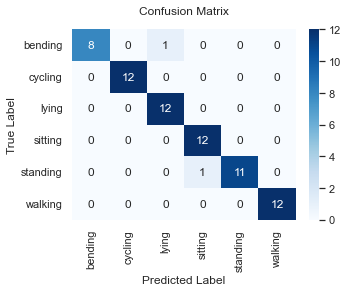


Confusion Matrix for Test Data


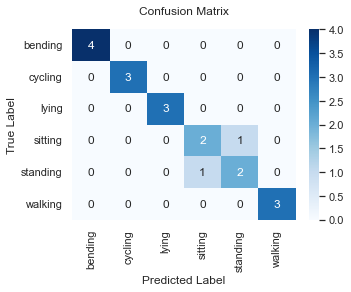



ROC Curve for Train Data:


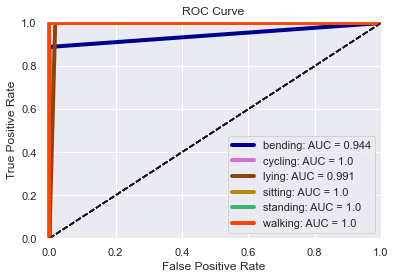



ROC Curve for Test Data:


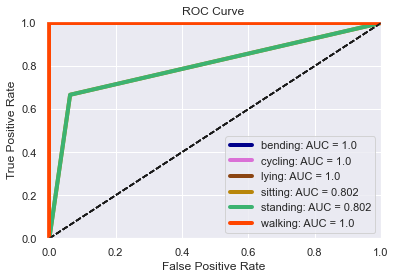

In [46]:
print("\nConfusion Matrix for Train Data")
#Plotting the confusion matrix (Train Data)
plt.figure(figsize=(5,3.5))
sns.heatmap(confusion_matrix(ytrain,ypred_train),annot=True,cmap="Blues", fmt="d", 
            xticklabels = label_encoder.classes_, 
            yticklabels = label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix",pad=15)
plt.show()


print("\nConfusion Matrix for Test Data")
#Plotting the confusion matrix (Test Data)
plt.figure(figsize=(5,3.5))
sns.heatmap(confusion_matrix(ytest,ypred_test),annot=True,cmap="Blues", fmt="d", 
            xticklabels = label_encoder.classes_, 
            yticklabels = label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix",pad=15)
plt.show()

#ROC
#Train Data
print("\n\nROC Curve for Train Data:")

colors = ("darkblue","orchid","saddlebrown","darkgoldenrod","mediumseagreen","orangered")
cnt = 0
col_mapper = dict(zip('012345',label_encoder.classes_))
for i in train_pred.columns:
    
    ytrain_new = [1 if c==int(i) else 0 for c in ytrain]    
    fpr,tpr,_ = roc_curve(ytrain_new,train_pred.loc[:,i].values)
    roc_auc = auc(fpr, tpr)
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, c = colors[cnt],label = f'{col_mapper[i]}: AUC = {round(roc_auc,3)}',lw=4)
    cnt+=1
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'k--')

        
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#ROC
#Test Data
print("\n\nROC Curve for Test Data:")

cnt = 0
col_mapper = dict(zip('012345',label_encoder.classes_))
for i in test_pred.columns:
    ytest_new = [1 if c==int(i) else 0 for c in ytest]    
    fpr,tpr,_ = roc_curve(ytest_new,test_pred.loc[:,i].values.flatten())
    roc_auc = auc(fpr, tpr)
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, c = colors[cnt],label = f'{col_mapper[i]}: AUC = {round(roc_auc,3)}',lw=4)
    cnt+=1
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'k--')

        
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

https://stats.stackexchange.com/questions/263121/why-are-the-roc-curves-not-smooth

#### iii. Which method is better for multi-class classification in this problem?

After comparation, we can see L1-norm logistic regression has the best performance which gives best test score 0.947368.

### ISLR 4.8.3

This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a class specific mean vector and a class specific covariance matrix. We consider the simple case where p = 1; i.e. there is only one feature. Suppose that we have K classes, and that if an observation belongs to the kth class then X comes from a one-dimensional normal distribution, X ∼ N(µk, σ2 k). Recall that the density function for the one-dimensional normal distribution is given in (4.16). Prove that in this case, the Bayes classifier is not linear. Argue that it is in fact quadratic.

### ISLR 4.8.7 

Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit. We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was X¯ = 10, while the mean for those that didn’t was X¯ = 0. In addition, the variance of X for these two sets of companies was ˆσ2 = 36. Finally, 80 % of companies issued dividends. Assuming that X follows a normal distribution, predict the probability that a company will issue a dividend this year given that its percentage profit was X = 4 last year. Hint: Recall that the density function for a normal random variable is f(x) = √ 1 2πσ2 e−(x−µ)2/2σ2 . You will need to use Bayes’ theorem.